# DonorsChoose: Donor-Project Matching with Recommender Systems
Data and project idea come from a [Kaggle competition](https://www.kaggle.com/donorschoose/io).
Much of the recommender work is based on a [tutorial](https://www.kaggle.com/gspmoreira/recommender-systems-in-python-101/code) by [Gabriel Moreira](https://www.kaggle.com/gspmoreira) and this [kernel](https://www.kaggle.com/ranliu/donor-project-matching-with-recommender-systems) by [RanLiu](https://www.kaggle.com/ranliu).

# Donors Choose
Founded in 2000 by a Bronx history teacher, DonorsChoose.org has raised $685 million for America's classrooms. Teachers at three-quarters of all the public schools in the U.S. have come to DonorsChoose.org to request what their students need, making DonorsChoose.org the leading platform for supporting public education.

To date, 3 million people and partners have funded 1.1 million DonorsChoose.org projects. But teachers still spend more than a billion dollars of their own money on classroom materials. To get students what they need to learn, the team at DonorsChoose.org needs to be able to connect donors with the projects that most inspire them.

In the second Kaggle Data Science for Good challenge, DonorsChoose.org, in partnership with Google.org, is inviting the community to help them pair up donors to the classroom requests that will most motivate them to make an additional gift. To support this challenge, DonorsChoose.org has supplied anonymized data on donor giving from the past five years. The winning methods will be implemented in DonorsChoose.org email marketing campaigns.


# Problem Statement
DonorsChoose.org has funded over 1.1 million classroom requests through the support of 3 million donors, the majority of whom were making their first-ever donation to a public school. If DonorsChoose.org can motivate even a fraction of those donors to make another donation, that could have a huge impact on the number of classroom requests fulfilled.

A good solution will enable DonorsChoose.org to build targeted email campaigns recommending specific classroom requests to prior donors. Part of the challenge is to assess the needs of the organization, uncover insights from the data available, and build the right solution for this problem. Submissions will be evaluated on the following criteria:

Performance - How well does the solution match donors to project requests to which they would be motivated to donate? DonorsChoose.org will not be able to live test every submission, so a strong entry will clearly articulate why it will be effective at motivating repeat donations.

Adaptable - The DonorsChoose.org team wants to put the winning submissions to work, quickly. Therefore a good entry will be easy to implement in production.

Intelligible - A good entry should be easily understood by the DonorsChoose.org team should it need to be updated in the future to accommodate a changing marketplace.

# Proposed Solution

I will address the problem by using [Recommender System](https://en.wikipedia.org/wiki/Recommender_system) (RecSys) techniques. The objective of a RecSys is to recommend relevant items for users, based on their preference. Preference and relevance are subjective, and they are generally inferred by items users have consumed previously.

The main RecSys techniques are:  
   - [**Collaborative Filtering**](https://en.wikipedia.org/wiki/Collaborative_filtering): This method makes automatic predictions (filtering) about the interests of a user by collecting preferences or taste information from many users (collaborating). The underlying assumption of the collaborative filtering approach is that if a person A has the same opinion as a person B on a set of items, A is more likely to have B's opinion for a given item than that of a randomly chosen person.   
   - [**Content-Based Filtering**](http://recommender-systems.org/content-based-filtering/): This method uses only information about the description and attributes of the items users has previously consumed to model user's preferences. In other words, these algorithms try to recommend items that are similar to those that a user liked in the past (or is examining in the present). In particular, various candidate items are compared with items previously rated by the user and the best-matching items are recommended.  
   - **Hybrid methods**:  Recent research has demonstrated that a hybrid approach, combining collaborative filtering and content-based filtering could be more effective than pure approaches in some cases. These methods can also be used to overcome some of the common problems in recommender systems such as cold start and the sparsity problem.

## Load libraries

In [1]:
# Set up test mode to save some time
test_mode = True

In [2]:
import numpy as np
import scipy
import pandas as pd
import math
import random
import sklearn
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
import seaborn as sns # for making plots with seaborn
color = sns.color_palette()
%matplotlib inline

# Any results you write to the current directory are saved as output.

## The Problem

DonorsChoose.org has funded over 1.1 million classroom requests through the support of 3 million donors, the majority of whom were making their first-ever donation to a public school. If DonorsChoose.org can motivate even a fraction of those donors to make another donation, that could have a huge impact on the number of classroom requests fulfilled. A good solution will enable DonorsChoose.org to build targeted email campaigns recommending specific classroom requests to prior donors. 

## The Strategy: Recommender systems (RecSys)

I consider this task a recommender system (RecSys) problem. Donors are similar to users or customers of a online platform providing various products. Let's take a music site for example: when a user named Emma listened to one or more songs at our site, we will be able to recommend more songs to her based on her listening history and the listening history of people who are similar to her.  Similarly, once a donor named Alice donated to one or more projects at DonorsChoose.org, we will be able to recommend more projects to her based on her donation history and the donation history of other donors who are similar to her. 

Therefore, I propose the following three approaches to solve this problem: 

* **Content-Based Filtering**: This method uses only information about the description and attributes of the projects donors has previously donated to when modeling the donor's preferences. In other words, these algorithms try to recommend projects that are similar to those that a donor has donated to in the past.  In particular, various candidate projects are compared with projects the donor has donated to, and the best-matching projects will be recommended.

* **Collaborative Filtering**: This method makes automatic predictions (filtering) about the preference of a donor by collecting preferences from many other donors (collaborating). It predicts what a particular donor will donate to based on what projects other similar donors have donated to. The underlying assumption of the collaborative filtering approach is that if Alice and Bob have donated to the same project(s), Alice is more likely to share Bob's preference for a given project than that of a randomly chosen donor.

* **Hybrid methods**: Most companies like Netflix and Hulu use a hybrid approach in their recommendation models, which provide recommendation based on the combination of what content a user like in the past as well as what other similar user like. Recent research has demonstrated that a hybrid approach that combines collaborative filtering and content-based filtering could be more effective than both approaches in some cases. These hybrid methods can also be used to overcome some of the common problems in recommender systems such as cold start and the sparsity problem.

## Pre-processing and EDA

Before getting into the recommender systems, we will load and preprocess our datasets. The next code block is hidden in the notebook mode to facilitate reading, but the code creates two datasets: "projects" contains all project-related information, while "donations_df" contains donations- and donors-related information.  To make sure the code runs smoothly in Kaggle kernel, I turned on the **test mode** to only keep 10000 donation events in the dataset. 

In [66]:
# Read datasets
projects = pd.read_csv('Projects.csv')
donations = pd.read_csv('Donations.csv')
donors = pd.read_csv('Donors.csv')
resources = pd.read_csv('Resources.csv')
teachers = pd.read_csv('Teachers.csv')
schools = pd.read_csv('Schools.csv')

#this piece of code converts Project_ID which is a 32-bit Hex int digits 10-1010
# create column "project_id" with sequential integers
f=len(projects)
g = list(range(10,f+10))
g = pd.Series(g)
projects['project_id'] = g.values

#this piece of code converts Donor_ID which is a 32-bit Hex int digits 10-1010
# create column "donor_id" with sequential integers
b=len(donors)
#donors['donor_id'] = np.nan
a = list(range(10,b+10))
a = pd.Series(a)
donors['donor_id'] = a.values

# Merge datasets
dd = donations.merge(donors, on="Donor ID", how="left")
ddp = donations.merge(projects,on="Project ID", how="left")

df = ddp
# only load a few lines in test mode
if test_mode:
    df = df.head(10000)

donations_df = df

/Users/degraff/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [68]:
ddp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4687887 entries, 0 to 4687886
Data columns (total 22 columns):
Project ID                             object
Donation ID                            object
Donor ID                               object
Donation Included Optional Donation    object
Donation Amount                        float64
Donor Cart Sequence                    int64
Donation Received Date                 object
School ID                              object
Teacher ID                             object
Teacher Project Posted Sequence        int64
Project Type                           object
Project Title                          object
Project Essay                          object
Project Subject Category Tree          object
Project Subject Subcategory Tree       object
Project Grade Level Category           object
Project Resource Category              object
Project Cost                           object
Project Posted Date                    object
Project Curren

In [7]:
print(' donations: ',donations.shape,'\n','donors: ',donors.shape,'\n','projects:',projects.shape,'\n','resources:',resources.shape,'\n','teachers:',teachers.shape, '\n','schools:',schools.shape)

 donations:  (4687884, 12) 
 donors:  (2122640, 6) 
 projects: (1208651, 16) 
 resources: (7210448, 5) 
 teachers: (402900, 3) 
 schools: (72993, 9)


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 27 columns):
Project ID                             10000 non-null object
Donation ID                            10000 non-null object
Donor ID                               10000 non-null object
Donation Included Optional Donation    10000 non-null object
Donation Amount                        10000 non-null float64
Donor Cart Sequence                    10000 non-null int64
Donation Received Date                 10000 non-null object
Donor City                             9283 non-null object
Donor State                            9983 non-null object
Donor Is Teacher                       9983 non-null object
Donor Zip                              9473 non-null object
donor_id                               9983 non-null float64
School ID                              10000 non-null object
Teacher ID                             10000 non-null object
Teacher Project Posted Sequence        100

In [5]:
df.columns

Index(['Project ID', 'Donation ID', 'Donor ID',
       'Donation Included Optional Donation', 'Donation Amount',
       'Donor Cart Sequence', 'Donation Received Date', 'Donor City',
       'Donor State', 'Donor Is Teacher', 'Donor Zip', 'donor_id', 'School ID',
       'Teacher ID', 'Teacher Project Posted Sequence', 'Project Type',
       'Project Title', 'Project Essay', 'Project Subject Category Tree',
       'Project Subject Subcategory Tree', 'Project Grade Level Category',
       'Project Resource Category', 'Project Cost', 'Project Posted Date',
       'Project Current Status', 'Project Fully Funded Date', 'project_id'],
      dtype='object')

In [6]:
df.head(5)

,Project ID,Donation ID,Donor ID,Donation Included Optional Donation,Donation Amount,Donor Cart Sequence,Donation Received Date,Donor City,Donor State,Donor Is Teacher,...,Project Essay,Project Subject Category Tree,Project Subject Subcategory Tree,Project Grade Level Category,Project Resource Category,Project Cost,Project Posted Date,Project Current Status,Project Fully Funded Date,project_id
0,000009891526c0ade7180f8423792063,688729120858666221208529ee3fc18e,1f4b5b6e68445c6c4a0509b3aca93f38,No,178.37,11,2016-08-23 13:15:57,West Jordan,Utah,No,...,the music students in our classes perform freq...,Music & The Arts,Music,Grades 6-8,Other,$529.68,2016-05-13,Fully Funded,2016-08-23,573748
1,000009891526c0ade7180f8423792063,dcf1071da3aa3561f91ac689d1f73dee,4aaab6d244bf3599682239ed5591af8a,Yes,25.00,2,2016-06-06 20:05:23,Riverton,Utah,Yes,...,the music students in our classes perform freq...,Music & The Arts,Music,Grades 6-8,Other,$529.68,2016-05-13,Fully Funded,2016-08-23,573748
2,000009891526c0ade7180f8423792063,18a234b9d1e538c431761d521ea7799d,0b0765dc9c759adc48a07688ba25e94e,Yes,20.00,3,2016-06-06 14:08:46,Riverton,Utah,No,...,the music students in our classes perform freq...,Music & The Arts,Music,Grades 6-8,Other,$529.68,2016-05-13,Fully Funded,2016-08-23,573748
3,000009891526c0ade7180f8423792063,38d2744bf9138b0b57ed581c76c0e2da,377944ad61f72d800b25ec1862aec363,Yes,25.00,1,2016-05-15 10:23:04,Phoenix,Arizona,No,...,the music students in our classes perform freq...,Music & The Arts,Music,Grades 6-8,Other,$529.68,2016-05-13,Fully Funded,2016-08-23,573748
4,000009891526c0ade7180f8423792063,5a032791e31167a70206bfb86fb60035,6d5b22d39e68c656071a842732c63a0c,Yes,25.00,2,2016-05-17 01:23:38,Salt Lake City,Utah,Yes,...,the music students in our classes perform freq...,Music & The Arts,Music,Grades 6-8,Other,$529.68,2016-05-13,Fully Funded,2016-08-23,573748


In [9]:
donations.head(3)

,Project ID,Donation ID,Donor ID,Donation Included Optional Donation,Donation Amount,Donor Cart Sequence,Donation Received Date,Donor City,Donor State,Donor Is Teacher,Donor Zip,donor_id
0,000009891526c0ade7180f8423792063,688729120858666221208529ee3fc18e,1f4b5b6e68445c6c4a0509b3aca93f38,No,178.37,11,2016-08-23 13:15:57,West Jordan,Utah,No,840,259744.0
1,000009891526c0ade7180f8423792063,dcf1071da3aa3561f91ac689d1f73dee,4aaab6d244bf3599682239ed5591af8a,Yes,25.00,2,2016-06-06 20:05:23,Riverton,Utah,Yes,840,619262.0
2,000009891526c0ade7180f8423792063,18a234b9d1e538c431761d521ea7799d,0b0765dc9c759adc48a07688ba25e94e,Yes,20.00,3,2016-06-06 14:08:46,Riverton,Utah,No,840,91756.0


In [72]:
donors.head(3)

,Donor ID,Donor City,Donor State,Donor Is Teacher,Donor Zip,donor_id
0,00000ce845c00cbf0686c992fc369df4,Evanston,Illinois,No,602,10
1,00002783bc5d108510f3f9666c8b1edd,Appomattox,other,No,245,11
2,00002d44003ed46b066607c5455a999a,Winton,California,Yes,953,12


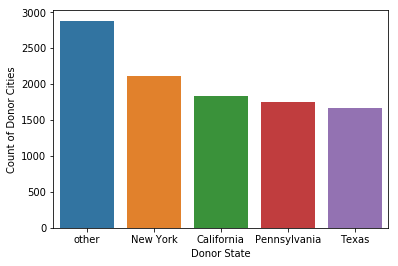

In [58]:
df = donors.groupby("Donor State")['Donor City'].nunique().to_frame().reset_index()
X = df['Donor State'].tolist()
Y = df['Donor City'].apply(float).tolist()
Z = [x for _,x in sorted(zip(Y,X))]

data = pd.DataFrame({'Donor State' : Z[-5:][::-1], 'Count of Donor Cities' : sorted(Y)[-5:][::-1] })
sns.barplot(x="Donor State",y="Count of Donor Cities",data=data)

In [ ]:
donor_state = donors['Donor State'].value_counts().head(10).sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(19,9))
sns.barplot(donor_state.values, donor_state.index, ax=ax)
ax.set(xlabel= 'Number of Donors', 
       ylabel = 'State', 
       title = "Distribution of Donors by State")
plt.show()

In [11]:
projects.head(3)

,Project ID,School ID,Teacher ID,Teacher Project Posted Sequence,Project Type,Project Title,Project Essay,Project Subject Category Tree,Project Subject Subcategory Tree,Project Grade Level Category,Project Resource Category,Project Cost,Project Posted Date,Project Current Status,Project Fully Funded Date,project_id
0,77b7d3f2ac4e32d538914e4a8cb8a525,c2d5cb0a29a62e72cdccee939f434181,59f7d2c62f7e76a99d31db6f62b7b67c,2,Teacher-Led,Anti-Bullying Begins with Me,do you remember your favorite classroom from e...,"Applied Learning, Literacy & Language","Character Education, Literacy",Grades PreK-2,Books,$490.38,2013-01-01,Fully Funded,2013-03-12,10
1,fd928b7f6386366a9cad2bea40df4b25,8acbb544c9215b25c71a0c655200baea,8fbd92394e20d647ddcdc6085ce1604b,1,Teacher-Led,Ukuleles For Middle Schoolers,what sound is happier than a ukulele? we have...,Music & The Arts,Music,Grades 6-8,Supplies,$420.61,2013-01-01,Expired,NaN,11
2,7c915e8e1d27f10a94abd689e99c336f,0ae85ea7c7acc41cffa9f81dc61d46df,9140ac16d2e6cee45bd50b0b2ce8cd04,2,Teacher-Led,"Big Books, Flip Books, And Everything In Between","my 1st graders may be small, but they have big...","Literacy & Language, Special Needs","Literacy, Special Needs",Grades PreK-2,Books,$510.46,2013-01-01,Fully Funded,2013-01-07,12


Text(0.5,1,'Unique project title')

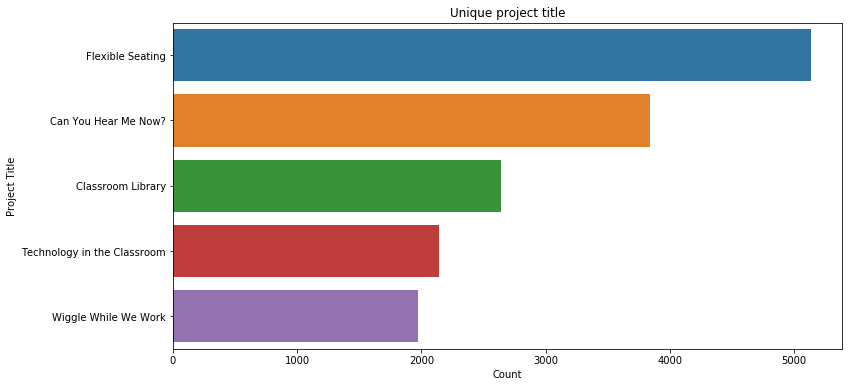

In [67]:
project_title = ddp['Project Title'].value_counts().to_frame().reset_index()[:5]
project_title = project_title.rename(columns= {'index': 'Project Title','Project Title':'Count'})
sns.barplot(x="Count",y="Project Title",data=project_title).set_title('Unique project title')

In [12]:
resources.head(3)

,Project ID,Resource Item Name,Resource Quantity,Resource Unit Price,Resource Vendor Name
0,000009891526c0ade7180f8423792063,chair move and store cart,1.0,350.00,NaN
1,00000ce845c00cbf0686c992fc369df4,sony mdr zx100 blk headphones,40.0,12.86,CDW-G
2,00002d44003ed46b066607c5455a999a,"gaiam kids stay-n-play balance ball, grey",4.0,19.00,Amazon Business


In [13]:
schools.head(3)

,School ID,School Name,School Metro Type,School Percentage Free Lunch,School State,School Zip,School City,School County,School District
0,00003e0fdd601b8ea0a6eb44057b9c5e,Capon Bridge Middle School,rural,56.0,West Virginia,26711,Capon Bridge,Hampshire,Hampshire Co School District
1,00004e32a448b4832e1b993500bf0731,The Woodlands College Park High School,urban,41.0,Texas,77384,The Woodlands,Montgomery,Conroe Ind School District
2,0002021bb799f28de224f1acc1ff08c4,Samantha Smith Elementary School,suburban,2.0,Washington,98074,Sammamish,King,Lake Washington Sch Dist 414


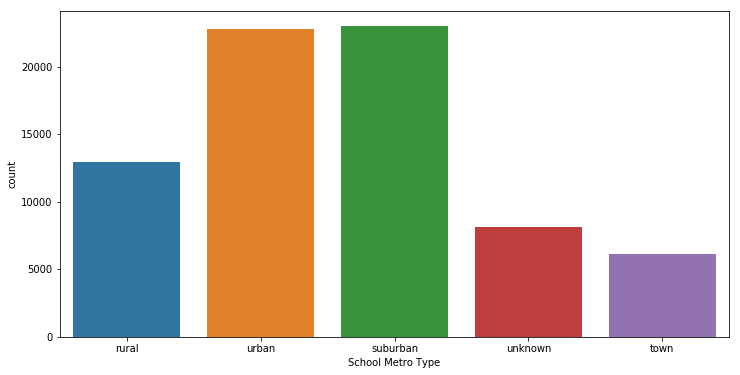

In [59]:
plt.rcParams["figure.figsize"] = [12,6]
sns.countplot(x='School Metro Type',data = schools)

In [14]:
teachers.head(3)

,Teacher ID,Teacher Prefix,Teacher First Project Posted Date
0,00000f7264c27ba6fea0c837ed6aa0aa,Mrs.,2013-08-21
1,00002d44003ed46b066607c5455a999a,Mrs.,2016-10-23
2,00006084c3d92d904a22e0a70f5c119a,Mr.,2016-09-08


In [16]:
donations_per_donor = donations.groupby('Donor ID')['Donor Cart Sequence'].max()
donations_per_donor1 = round(((donations_per_donor == 1).mean() *100),2)
print("No more than 1 donation is given by: "+ str(donations_per_donor1) +"% donors")
donations_per_donor_more_than_1 = round(((donations_per_donor > 1).mean() *100),2)
print("More than 1 donation is given by: "+ str(donations_per_donor_more_than_1) +"% donors")

No more than 1 donation is given by: 68.93% donors
More than 1 donation is given by: 31.07% donors


In [17]:
donations_per_donor = donations.groupby('Donor ID')['Donor Cart Sequence'].max()
donations_per_donor1 = round(((donations_per_donor == 1).mean() *100),3)
donations_per_donor_under_5 = (donations_per_donor < 5).mean() *100
donations_per_donor_under_10 = (donations_per_donor <10).mean() *100
donations_per_donor_under_15 = (donations_per_donor <15).mean() *100
donations_per_donor_under_20 = (donations_per_donor <20).mean() *100
donations_per_donor_under_25 = (donations_per_donor <25).mean() *100
donations_per_donor_under_30 = (donations_per_donor <30).mean() *100
donations_per_donor_over_29 = round(((donations_per_donor > 29).mean() *100),3)

between1_5=round(donations_per_donor_under_5-donations_per_donor1,3)
between5_10=round(donations_per_donor_under_10-donations_per_donor_under_5,3)
between10_15=round(donations_per_donor_under_15-donations_per_donor_under_10,3)
between15_20=round(donations_per_donor_under_20-donations_per_donor_under_15,3)
between20_25=round(donations_per_donor_under_25-donations_per_donor_under_20,3)
between25_30=round(donations_per_donor_under_30-donations_per_donor_under_25,3)

print("Only one time donation is given by: "+ str(donations_per_donor1) +"% donors")
print("2 to 4 donations are given by: "+ str(between1_5) +"% donors")
print("5 to 9 donations are given by: "+ str(between5_10) +"% donors")
print("10 to 14 donations are given by: "+ str(between10_15) +"% donors")
print("15 to 19 donations are given by: "+ str(between15_20) +"% donors")
print("20 to 24 donations are given by: "+ str(between20_25) +"% donors")
print("25 to 29 donations are given by: "+ str(between25_30) +"% donors")
print("29 or more donations are given by: "+ str(donations_per_donor_over_29) +"% donors")

Only one time donation is given by: 68.933% donors
2 to 4 donations are given by: 23.49% donors
5 to 9 donations are given by: 4.889% donors
10 to 14 donations are given by: 1.265% donors
15 to 19 donations are given by: 0.514% donors
20 to 24 donations are given by: 0.269% donors
25 to 29 donations are given by: 0.157% donors
29 or more donations are given by: 0.483% donors


In [18]:
donations_per_donor_under_10 = (donations_per_donor <10).mean() *100
donations_per_donor0 = (donations_per_donor > 0).mean() *100
donations_per_donor_over_9=round((donations_per_donor0-donations_per_donor_under_10),2)
print("10 or more donations are given by "+str(donations_per_donor_over_9)+"% donors")

10 or more donations are given by 2.69% donors


Before modeling, we need to measure the relation strength between a donor and a project. Although most donors only donate once in the dataset, there are donors who donated to the same project multiple times, and users who donated to multiple projects. The donation amount also varies. To better measure this strength, we combine the times and amounts of donations, and create a new dataset containing unique donation relations between a donor, a project, and the relation strength.  The hidden code block will output the number of projects and unique donor-project donation events:

In [19]:
# Deal with missing values
donations["Donation Amount"] = donations["Donation Amount"].fillna(0)

# Define event strength as the donated amount to a certain project
donations_df['eventStrength'] = donations_df['Donation Amount']

def smooth_donor_preference(x):
    return math.log(1+x, 2)
    
donations_full_df = donations_df \
                    .groupby(['Donor ID', 'Project ID'])['eventStrength'].sum() \
                    .apply(smooth_donor_preference).reset_index()
        
# Update projects dataset
project_cols = projects.columns
projects = df[project_cols].drop_duplicates()

print('# of projects: %d' % len(projects))
print('# of unique user/project donations: %d' % len(donations_full_df))

# of projects: 1889
# of unique user/project donations: 8648


Apparently, our test mode with 10000 donation events contains 1889 projects and 8648 unique user-project donations. We can also take a look at the first five rows of our donor-project dataset:

In [20]:
donations_full_df.head()

,Donor ID,Project ID,eventStrength
0,0003aba06ccf49f8c44fc2dd3b582411,0081553d51ed5d2529e2e38b0827133a,5.672425
1,000f7306e8ddb36296f0d97a34d67d76,007e2a1a47ce50ded4538692d0bf601b,4.700440
2,00125f251b05d9e447a5448bef981028,0055c89fe4b1085db791edeb67ace2e0,4.700440
3,0013dfb2a873420fe6e7d750ef24ce98,004baba788df541cc469c0f4f21493d6,3.087463
4,0016b23800f7ea46424b3254f016007a,004c7c5e1a8cbce0ee63d14574096aeb,5.672425


To evaluate our models, we will split the donation dataset into training and validation sets. 

In [21]:
donations_train_df, donations_test_df = train_test_split(donations_full_df,
                                   test_size=0.20,
                                   random_state=42)

print('# donations on Train set: %d' % len(donations_train_df))
print('# donations on Test set: %d' % len(donations_test_df))

#Indexing by Donor Id to speed up the searches during evaluation
donations_full_indexed_df = donations_full_df.set_index('Donor ID')
donations_train_indexed_df = donations_train_df.set_index('Donor ID')
donations_test_indexed_df = donations_test_df.set_index('Donor ID')

# donations on Train set: 6918
# donations on Test set: 1730


We are ready to move on to the recommender system models. 

## Content-Based Filtering model

The first approach, the Content-Based Filtering method, is to find projects that are similar to the project(s) that a donor has already donated to. We can calculate the similarity between projects based on metadata (project type, project category, grade level, resource category, cost, school location, etc) and/or text features extracted from the project titles and descriptions. In this solution, I mainly demonstrate how to implement the latter approach. 

We will use a very popular technique, TF-IDF, to extract information from project title and descriptions. TF-IDF converts unstructured text into a vector structure, where each word is represented by a position in the vector, and the value measures how relevant a given word is for a project title/descriptions. It is used bo compute similarity between projects based on project titles and descriptions. 

### Process text data

In [22]:
# Preprocessing of text data
textfeats = ["Project Title","Project Essay"]
for cols in textfeats:
    projects[cols] = projects[cols].astype(str) 
    projects[cols] = projects[cols].astype(str).fillna('') # FILL NA
    projects[cols] = projects[cols].str.lower() # Lowercase all text, so that capitalized words dont get treated differently
 
text = projects["Project Title"] + ' ' + projects["Project Essay"]
vectorizer = TfidfVectorizer(strip_accents='unicode',
                             analyzer='word',
                             lowercase=True, # Convert all uppercase to lowercase
                             stop_words='english', # Remove commonly found english words ('it', 'a', 'the') which do not typically contain much signal
                             max_df = 0.9, # Only consider words that appear in fewer than max_df percent of all documents
                             # max_features=5000 # Maximum features to be extracted                    
                            )                        
project_ids = projects['Project ID'].tolist()
tfidf_matrix = vectorizer.fit_transform(text)
tfidf_feature_names = vectorizer.get_feature_names()
tfidf_matrix

<1889x12490 sparse matrix of type '<class 'numpy.float64'>'
	with 182757 stored elements in Compressed Sparse Row format>

### Build donor profile

To build a donor's profile, we take all the projects the donor has donated to and average them. The average is weighted by the event strength based on donation times and amount. In other words, the project the donor has donated more money will have a higher strength in the final donor profile. 

The next code chunk builds donor profiles for all donors in our dataset, and return the total number of donors with profiles. 

In [23]:
def get_project_profile(project_id):
    idx = project_ids.index(project_id)
    project_profile = tfidf_matrix[idx:idx+1]
    return project_profile

def get_project_profiles(ids):
    project_profiles_list = [get_project_profile(x) for x in np.ravel([ids])]
    project_profiles = scipy.sparse.vstack(project_profiles_list)
    return project_profiles

def build_donors_profile(donor_id, donations_indexed_df):
    donations_donor_df = donations_indexed_df.loc[donor_id]
    donor_project_profiles = get_project_profiles(donations_donor_df['Project ID'])
    donor_project_strengths = np.array(donations_donor_df['eventStrength']).reshape(-1,1)
    #Weighted average of project profiles by the donations strength
    donor_project_strengths_weighted_avg = np.sum(donor_project_profiles.multiply(donor_project_strengths), axis=0) / (np.sum(donor_project_strengths)+1)
    donor_profile_norm = sklearn.preprocessing.normalize(donor_project_strengths_weighted_avg)
    return donor_profile_norm

from tqdm import tqdm

def build_donors_profiles(): 
    donations_indexed_df = donations_full_df[donations_full_df['Project ID'].isin(projects['Project ID'])].set_index('Donor ID')
    donor_profiles = {}
    for donor_id in tqdm(donations_indexed_df.index.unique()):
        donor_profiles[donor_id] = build_donors_profile(donor_id, donations_indexed_df)
    return donor_profiles

donor_profiles = build_donors_profiles()
print("# of donors with profiles: %d" % len(donor_profiles))

100%|██████████| 8015/8015 [00:07<00:00, 1006.15it/s]

# of donors with profiles: 8015


In test mode, we have built user profiles for 8015 donors. Let's take a look at one particular user's profile by displaying text tokens that are most relevant to this donor. 

In [24]:
donations_full_indexed_df.head(10)

,Project ID,eventStrength
Donor ID,,
0003aba06ccf49f8c44fc2dd3b582411,0081553d51ed5d2529e2e38b0827133a,5.672425
000f7306e8ddb36296f0d97a34d67d76,007e2a1a47ce50ded4538692d0bf601b,4.700440
00125f251b05d9e447a5448bef981028,0055c89fe4b1085db791edeb67ace2e0,4.700440
0013dfb2a873420fe6e7d750ef24ce98,004baba788df541cc469c0f4f21493d6,3.087463
0016b23800f7ea46424b3254f016007a,004c7c5e1a8cbce0ee63d14574096aeb,5.672425
00199e3565635f8a5ebefd3b5985a7f3,006a17f2eff0c3dae79630c295e2a666,7.838069
00309a47b765e12714d817ee3215de1e,006a366c97f485d4f349fad018d95f42,4.075533
0036448e416b71ab040182c428958b6f,000c43686474a41cbd1b04110149160c,4.700440
00393e12bc4f2eefa1a342a83559c2be,006a366c97f485d4f349fad018d95f42,5.672425


In [25]:
ind_mydonor=donations_full_indexed_df.index.values[0:20]

mydonor0 = ind_mydonor[0]
mydonor1 = ind_mydonor[1]
mydonor2 = ind_mydonor[2]
mydonor3 = ind_mydonor[3]
mydonor4 = ind_mydonor[4]
mydonor5 = ind_mydonor[5]
mydonor6 = ind_mydonor[6]
mydonor7 = ind_mydonor[7]
mydonor8 = ind_mydonor[8]
mydonor9 = ind_mydonor[9]
mydonor10 = ind_mydonor[10]
mydonor11 = ind_mydonor[11]
mydonor12 = ind_mydonor[12]
mydonor13 = ind_mydonor[13]
mydonor14 = ind_mydonor[14]
mydonor15 = ind_mydonor[15]
mydonor16 = ind_mydonor[16]
mydonor17 = ind_mydonor[17]
mydonor18 = ind_mydonor[18]
mydonor19 = ind_mydonor[19]

mydonor1_profile = pd.DataFrame(sorted(zip(tfidf_feature_names, 
                        donor_profiles[mydonor1].flatten().tolist()), 
                        key=lambda x: -x[1])[:10],
                        columns=['token', 'relevance'])
mydonor2_profile = pd.DataFrame(sorted(zip(tfidf_feature_names, 
                        donor_profiles[mydonor2].flatten().tolist()), 
                        key=lambda x: -x[1])[:10],
                        columns=['token', 'relevance'])

In [26]:
mydonor1_profile

,token,relevance
0,lacrosse,0.406918
1,sport,0.378110
2,sports,0.316206
3,oldest,0.256492
4,america,0.202604
5,north,0.198648
6,fastest,0.192952
7,late,0.157027
8,team,0.150857
9,athletes,0.146519


In [27]:
mydonor2_profile

,token,relevance
0,castles,0.322847
1,ed,0.259267
2,frames,0.253062
3,art,0.224827
4,love,0.200784
5,create,0.199808
6,picture,0.199157
7,writing,0.187631
8,express,0.181023
9,inspire,0.172123


Apparently, our content-based recommender figures that donor 1 is more interested in music-related projects, and donor 2 is more interested in projects about planting and reading. 

### Build the Content-Based Recommender

Now it's time to build our content-based recommender: 

In [28]:
class ContentBasedRecommender:
    
    MODEL_NAME = 'Content-Based'
    
    def __init__(self, projects_df=None):
        self.project_ids = project_ids
        self.projects_df = projects_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def _get_similar_projects_to_donor_profile(self, donor_id, topn=1000):
        #Computes the cosine similarity between the donor profile and all project profiles
        cosine_similarities = cosine_similarity(donor_profiles[donor_id], tfidf_matrix)
        #Gets the top similar projects
        similar_indices = cosine_similarities.argsort().flatten()[-topn:]
        #Sort the similar projects by similarity
        similar_projects = sorted([(project_ids[i], cosine_similarities[0,i]) for i in similar_indices], key=lambda x: -x[1])
        return similar_projects
        
    def recommend_projects(self, donor_id, projects_to_ignore=[], topn=10, verbose=False):
        similar_projects = self._get_similar_projects_to_donor_profile(donor_id)
        #Ignores projects the donor has already donated
        similar_projects_filtered = list(filter(lambda x: x[0] not in projects_to_ignore, similar_projects))
        
        recommendations_df = pd.DataFrame(similar_projects_filtered, columns=['Project ID', 'recStrength']).head(topn)

        recommendations_df = recommendations_df.merge(self.projects_df, how = 'left', 
                                                    left_on = 'Project ID', 
                                                    right_on = 'Project ID')[['recStrength', 'Project ID', 'Project Title', 'Project Essay']]


        return recommendations_df


Let's use this Content-Based Recommender to see what it will recommend to my donor:

In [29]:
cbr_model = ContentBasedRecommender(projects)
cbr_model.recommend_projects(mydonor1)

,recStrength,Project ID,Project Title,Project Essay
0,1.000000,007e2a1a47ce50ded4538692d0bf601b,lacrosse: why listen about it when you can lea...,why should my students sit in desks to learn a...
1,0.224786,00257d63a4f3e5979351759ef90fc19c,let's gear up for sports,my students have special needs and need hands-...
2,0.185660,0064248ca5366d3b0f52a13ab57625fe,speed stacks for cognitive development and han...,a challenge facing my students both inside and...
3,0.168702,00782b5d7f353a6a5c12ad2c0adce360,sports matter! help us bring soccer to our sc...,we provide a rigorous bilingual academic progr...
4,0.157276,00714ce7dc91effc9b266640aebe2e95,girls volleyball skill building,"""there is no glory in practice, but without pr..."
5,0.149993,00563bb84f4bfb6ce7a70ff4931a1bf2,don't sit on the bench- get in the game!,my school is located in a rural area on the ou...
6,0.149214,00404daee8c77f1565e87c93e9183ec8,equipment for our awesome girls softball team!,imagine having 18 girls excited and ready for ...
7,0.140554,0043d0c13580720dcdd6fe7fc47442db,practicing precision: badminton!,our badminton team is a great group of individ...
8,0.138574,0068f3f3fe8c911aa23f6dddd6842993,our heroes: a mural bigger than sports,my students are from a very challenging high s...
9,0.132175,00774dc035d5e643250c4ee96459ec7b,sports camps for kids!,"our school is located in south central, los an..."


In [30]:
cbr_model.recommend_projects(mydonor2)

,recStrength,Project ID,Project Title,Project Essay
0,1.000000,0055c89fe4b1085db791edeb67ace2e0,kindergarten students empowered through art...,"at the end of the school year, i would love fo..."
1,0.253029,0000d4777d14b33a1406dd6c9019fe89,artistic creativity here we come!,our school is amazing with wonderful artistic ...
2,0.237152,003cf9c97245f7b95171b2fc4dc8a9a4,the colorful art classroom,i have been able to introduce my students to n...
3,0.221125,001206ea335bb1e6b91614e915de941d,"""every child is an artist"" pablo picasso","""creativity is inventing, experimenting, growi..."
4,0.211380,003cfcc0c2ced54a9acfa9478fe33899,artful learning through reading,our third grade is comprised of 22 creative an...
5,0.209826,006e8bb6283132856529410247aea983,little picassos need art supplies,my pre-k students are four and five year of a...
6,0.209620,00584269b48696db32f60172d15e3ecf,little humans art exhibit,"every day, i begin with a lesson focusing on t..."
7,0.198851,004f3f81045ab9c1bc31d5f1e5dd4e13,creating works of art in writing and beyond!,our upper elementary school serves 3rd-5th gra...
8,0.194365,007eb73952edcd90d48cf1e2454462e5,we need color!,"""your attitude is like a box of crayons that c..."
9,0.194199,001cd1a7b01d4630d217128fd6235e60,i can make a 3-d painting!,save our art class! we need your help to conti...


It recommends music projects to donor 1, and gardening and reading projects to donor 2. 

This is because our donor 1 has donated to music project(s) before,  and donor 2 has donated to gardening and reading projects; the Content-Based Recommender successfully finds similar projects for our donors based on the project titles and descriptions. 

## Collaborative Filtering Model

Next, we will build a model-based Collaborative Filtering (CF) Recommender. In this approach, models are developed using machine learning algorithms to recommend project to donors. There are many model-based CF algorithms, here we adopt a latent factor model, which compresses donor-project matrix into a low-dimensional representation in terms of latent factors. A reduced presentation could be utilized for either donor-based or project-based neighborhood searching algorithms to find recommendations. Here we a use popular latent factor model named Singular Value Decomposition (SVD). 

### Create the donor-project matrix

We will first get the donor-project matrix and print the first five rows. 

In [31]:
#Creating a sparse pivot table with donors in rows and projects in columns
donors_projects_pivot_matrix_df = donations_full_df.pivot(index='Donor ID', 
                                                          columns='Project ID', 
                                                          values='eventStrength').fillna(0)

donors_projects_pivot_matrix_df.head(3)

Project ID,000009891526c0ade7180f8423792063,00000ce845c00cbf0686c992fc369df4,00002d44003ed46b066607c5455a999a,00002eb25d60a09c318efbd0797bffb5,0000300773fe015f870914b42528541b,00005454366b6b914f9a8290f18f4aed,00006084c3d92d904a22e0a70f5c119a,00008f7aaca8ab932c1bc1d0bc449186,0000bbd74feb563a324fe441eae19feb,0000be4b3c81e1cef858d536bb740052,...,0088e4da977c2212a9d139eed674c41e,0088f02c1b952f6bfa47a1574f9e13ba,00890175f65d97aa2f859c8e7faf9eda,0089083ff9978e1a8d55ac231b39d8bf,0089103efba54cca12e16d336b1612c7,0089118ee1816d34fd680c8b12e0d31a,008914744ac8a5c273eff7c29c6cc169,00891f05dd76342b8f287ac50f0d2525,00897214102859c52600f4acab28eeeb,0089759ee8b44b9f3908059f10510d94
Donor ID,,,,,,,,,,,,,,,,,,,,,
0003aba06ccf49f8c44fc2dd3b582411,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
000f7306e8ddb36296f0d97a34d67d76,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00125f251b05d9e447a5448bef981028,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
# Transform the donor-project dataframe into a matrix
donors_projects_pivot_matrix = donors_projects_pivot_matrix_df.as_matrix()
donors_projects_pivot_matrix[:3]

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [53]:
# Get donor ids
donors_ids = list(donors_projects_pivot_matrix_df.index)


In [34]:
# Print the first 5 rows of the donor-project matrix
donors_projects_pivot_matrix[:5]

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

Now we are ready to compresses donor-project matrix into a low-dimensional representation in terms of latent factors.

### Singular Value Decomposition (SVD)

Now we will use SVD to get latent factors. After the factorization, we will try to reconstruct the original matrix by multiplying its factors. The resulting matrix is not sparse any more. It is the generated predictions for projects the donor have not yet donated to, which we will exploit for recommendations.

In [35]:
# Performs matrix factorization of the original donor-project matrix
# Here we set k = 20, which is the number of factors we are going to get
# In the definition of SVD, an original matrix A is approxmated as a product A ≈ UΣV 
# where U and V have orthonormal columns, and Σ is non-negative diagonal.
#The number of factors to factor the user-item matrix.
NUMBER_OF_FACTORS_MF = 20
#Performs matrix factorization of the original user item matrix
U, sigma, Vt = svds(donors_projects_pivot_matrix, k = NUMBER_OF_FACTORS_MF)

In [36]:
U.shape

(8015, 20)

In [37]:
Vt.shape

(20, 1889)

In [38]:
sigma = np.diag(sigma)
sigma.shape

(20, 20)

In [39]:
# Reconstruct the matrix by multiplying its factors
all_donor_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 

In [40]:
#Converting the reconstructed matrix back to a Pandas dataframe
cf_preds_df = pd.DataFrame(all_donor_predicted_ratings, 
                           columns = donors_projects_pivot_matrix_df.columns, 
                           index=donors_ids).transpose()
cf_preds_df.head()

,0003aba06ccf49f8c44fc2dd3b582411,000f7306e8ddb36296f0d97a34d67d76,00125f251b05d9e447a5448bef981028,0013dfb2a873420fe6e7d750ef24ce98,0016b23800f7ea46424b3254f016007a,00199e3565635f8a5ebefd3b5985a7f3,00309a47b765e12714d817ee3215de1e,0036448e416b71ab040182c428958b6f,00393e12bc4f2eefa1a342a83559c2be,0052dd04a7cf2d91db791c94dec448ac,...,ffd58b0a2eb6d23a2abc3b795cc3f3b4,ffd77d71f8e2cf56763fcfe6eebb6f4e,ffdd0a22443cffe1e9328a0636a83269,ffe8f913768bd48b55806b205c7ddec6,ffedd6d373d17a8ee18946782a4417f4,fff4f5017a261c5e0c55651d4169fc10,fff86883f7f9a80f04f67a383c037dbe,fff8abd77bb426a75384823ebbb91403,fffb08cc7692aea6059a86dc0ba94b4c,ffff088c35d3455779a30898d1327b76
Project ID,,,,,,,,,,,,,,,,,,,,,
000009891526c0ade7180f8423792063,9.560984e-34,-4.005710e-34,-9.163746e-35,1.520699e-34,-2.171732e-33,1.683549e-33,4.180724e-33,-1.874660e-19,5.818834e-33,4.235056e-33,...,-6.235839e-33,7.054530e-33,-4.954597e-34,7.773420e-34,6.297102e-33,-1.181465e-17,2.249937e-33,-7.599631e-35,-2.570422e-33,5.945876e-33
00000ce845c00cbf0686c992fc369df4,3.367551e-36,1.588931e-35,-2.244192e-36,4.088608e-36,2.336141e-36,3.346520e-36,3.359356e-33,-3.979742e-23,4.675634e-33,-4.014829e-36,...,9.640636e-36,9.279526e-36,-7.006270e-36,2.822695e-36,-2.241528e-36,-1.180975e-20,-5.091200e-35,6.082573e-36,-4.024599e-36,-1.137865e-34
00002d44003ed46b066607c5455a999a,-2.522976e-33,7.462869e-33,1.619967e-33,2.704905e-33,2.279887e-33,-8.491377e-33,-8.817503e-31,-4.209169e-19,-1.227242e-30,-2.492054e-33,...,6.540343e-33,2.993545e-33,9.046553e-33,-1.380258e-33,-3.473777e-33,-2.474811e-17,5.171601e-34,-2.897239e-33,1.185290e-32,3.616177e-33
00002eb25d60a09c318efbd0797bffb5,-2.702844e-33,-5.414508e-33,-2.543639e-34,-1.491128e-33,6.152545e-34,-6.030192e-34,-7.749557e-32,7.482203e-19,-1.078602e-31,-3.295637e-33,...,-9.247205e-35,-2.338312e-32,4.744833e-33,-2.281558e-33,-6.289836e-33,-2.132972e-17,1.557183e-33,-8.945804e-35,1.845345e-33,1.310250e-32
0000300773fe015f870914b42528541b,6.774282e-34,-3.919547e-34,-1.137368e-34,-1.871881e-34,-1.911900e-34,1.285950e-33,7.629999e-32,1.489979e-19,1.061962e-31,1.314833e-34,...,-1.063634e-33,4.353831e-34,7.318887e-35,1.797665e-34,5.527249e-34,6.285750e-18,5.934619e-34,2.832038e-34,-2.096422e-33,2.826908e-33


### Build the Collaborative Filtering Model 

We are ready to build our collaborative filtering recommender! 

In [41]:
class CFRecommender:
    
    MODEL_NAME = 'Collaborative Filtering'
    
    def __init__(self, cf_predictions_df, projects_df=None):
        self.cf_predictions_df = cf_predictions_df
        self.projects_df = projects_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_projects(self, donor_id, projects_to_ignore=[], topn=10):
        # Get and sort the donor's predictions
        sorted_donor_predictions = self.cf_predictions_df[donor_id].sort_values(ascending=False) \
                                    .reset_index().rename(columns={donor_id: 'recStrength'})

        # Recommend the highest predicted projects that the donor hasn't donated to
        recommendations_df = sorted_donor_predictions[~sorted_donor_predictions['Project ID'].isin(projects_to_ignore)] \
                               .sort_values('recStrength', ascending = False) \
                               .head(topn)

 
        recommendations_df = recommendations_df.merge(self.projects_df, how = 'left', 
                                                          left_on = 'Project ID', 
                                                          right_on = 'Project ID')[['recStrength', 'Project ID', 'Project Title', 'Project Essay']]


        return recommendations_df


Let's look at its recommendations to our donor1 and donor2. 

In [42]:
cfr_model = CFRecommender(cf_preds_df, projects)
cfr_model.recommend_projects(mydonor1)

,recStrength,Project ID,Project Title,Project Essay
0,9.572967e-17,00082ce5c018610ecbf7cf57e8a064f2,coding wizards in a modern tech classroom!,"in this modern, digital age, i would like to u..."
1,8.001878e-17,0081e1f0d179795c8587804d28986af0,making music in kansas city,ca of kansas city is a tuition-free charter sc...
2,6.204952e-17,004ff83766737c4751008ec1d9f0e608,"3rd grade history, splash, and a whole lot of ...",the a. community and its students are a very s...
3,5.777944e-17,0066d5cb75c16a32bb569097798d747e,urban middle school band program needs new ins...,in my school 50% of the students are socioecon...
4,5.198095e-17,0078e2e24ae7e0de0817a5a17bd2f48c,little people - big minds,my students are african american and hispanic....
5,3.307994e-17,000529aa89291c6825144b8dbbd399ab,tower gardens for our school,as service learning coordinators at our elemen...
6,2.327990e-17,0066cfb9ded063e2078cf3973e2fa6aa,music for oyler,"my students do not have money, but they do hav..."
7,1.844449e-17,005fd7a92673d0747831d9cf89e8a8f0,mission: library rejuvination,sitting at a desk for a sustained period of ti...
8,4.837910e-18,001c0bc4441be6d1d75b38b53ef4d033,bring art and free expression to second chance...,"my students are transfer students, which means..."
9,4.077728e-18,0029e426fd3296af4fc333580fa895fe,"everyone needs an address, especially maniac m...","""...people will forget what you said, people w..."


In [43]:
cfr_model.recommend_projects(mydonor2)

,recStrength,Project ID,Project Title,Project Essay
0,3.392360e-17,00177290279939fb33386b29198c450e,reader's workshop = instilling a love of readi...,we are a brand new charter school that has onl...
1,2.675006e-17,000529aa89291c6825144b8dbbd399ab,tower gardens for our school,as service learning coordinators at our elemen...
2,2.379358e-17,0066cfb9ded063e2078cf3973e2fa6aa,music for oyler,"my students do not have money, but they do hav..."
3,2.020650e-17,00082ce5c018610ecbf7cf57e8a064f2,coding wizards in a modern tech classroom!,"in this modern, digital age, i would like to u..."
4,2.002048e-17,0078e2e24ae7e0de0817a5a17bd2f48c,little people - big minds,my students are african american and hispanic....
5,1.807756e-17,003425a6a801eec3e9f721b6dd297c3b,chemistry lab equipment,we are trying to engage more students in scien...
6,1.435623e-17,005fd7a92673d0747831d9cf89e8a8f0,mission: library rejuvination,sitting at a desk for a sustained period of ti...
7,1.281778e-17,0066d5cb75c16a32bb569097798d747e,urban middle school band program needs new ins...,in my school 50% of the students are socioecon...
8,2.237981e-18,004ff83766737c4751008ec1d9f0e608,"3rd grade history, splash, and a whole lot of ...",the a. community and its students are a very s...
9,8.198088e-19,00388e34c088cfc273a32642b67c7e60,chromebooks for keyboarding,our students are some of the hardest working k...


The recommendations are quite different this time. This is becaues the Collaborative Filtering model considers the donations made by other donors who have a similar preference to our donor. Therefore, popular projects are more likely to be seen here. 

## Hybrid Method

The third approach, the hybrid method, combines the first two approaches to try to give even better recommendations. Hybrid methods have performed better than individual approaches in many studies and have being extensively used by researchers and practioners.

Let's build a very simple hybridization method, by only multiply the Content-Based score with the Collaborative-Filtering score , and ranking by the resulting hybrid score.

In [44]:
class HybridRecommender:
    
    MODEL_NAME = 'Hybrid'
    
    def __init__(self, cb_rec_model, cf_rec_model, projects_df):
        self.cb_rec_model = cb_rec_model
        self.cf_rec_model = cf_rec_model
        self.projects_df = projects_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_projects(self, donor_id, projects_to_ignore=[], topn=10):
        #Getting the top-1000 Content-based filtering recommendations
        cb_recs_df = self.cb_rec_model.recommend_projects(donor_id, projects_to_ignore=projects_to_ignore, 
                                                           topn=1000).rename(columns={'recStrength': 'recStrengthCB'})
        
        #Getting the top-1000 Collaborative filtering recommendations
        cf_recs_df = self.cf_rec_model.recommend_projects(donor_id, projects_to_ignore=projects_to_ignore,  
                                                           topn=1000).rename(columns={'recStrength': 'recStrengthCF'})
        
        #Combining the results by Project ID
        recs_df = cb_recs_df.merge(cf_recs_df,
                                   how = 'inner', 
                                   left_on = 'Project ID', 
                                   right_on = 'Project ID')
        
        #Computing a hybrid recommendation score based on CF and CB scores
        recs_df['recStrengthHybrid'] = recs_df['recStrengthCB'] * recs_df['recStrengthCF']
        
        #Sorting recommendations by hybrid score
        recommendations_df = recs_df.sort_values('recStrengthHybrid', ascending=False).head(topn)

        recommendations_df = recommendations_df.merge(self.projects_df, how = 'left', 
                                                    left_on = 'Project ID', 
                                                    right_on = 'Project ID')[['recStrengthHybrid', 
                                                                              'Project ID', 'Project Title', 
                                                                              'Project Essay']]


        return recommendations_df
    
hybrid_model = HybridRecommender(cbr_model, cfr_model, projects)


Now let's look at the recommendations for our donor1 and donor2:

In [45]:
hybrid_model.recommend_projects(mydonor1)

,recStrengthHybrid,Project ID,Project Title,Project Essay
0,3.588910e-18,00082ce5c018610ecbf7cf57e8a064f2,coding wizards in a modern tech classroom!,"in this modern, digital age, i would like to u..."
1,2.174678e-18,0078e2e24ae7e0de0817a5a17bd2f48c,little people - big minds,my students are african american and hispanic....
2,1.919465e-18,004ff83766737c4751008ec1d9f0e608,"3rd grade history, splash, and a whole lot of ...",the a. community and its students are a very s...
3,1.349107e-18,0066cfb9ded063e2078cf3973e2fa6aa,music for oyler,"my students do not have money, but they do hav..."
4,6.511700e-19,005fd7a92673d0747831d9cf89e8a8f0,mission: library rejuvination,sitting at a desk for a sustained period of ti...
5,1.799260e-19,0082713393938adcd3cfb99a46305918,classroom library,i teach ela (reading component) to self-contai...
6,1.408793e-19,001c0bc4441be6d1d75b38b53ef4d033,bring art and free expression to second chance...,"my students are transfer students, which means..."
7,1.275774e-19,0001d58fba851d06ecb8a14853cfe257,going for the boing-g-g-g,“music expresses that which cannot be put into...
8,8.544623e-20,00173eb8e417bbe9fecc3da05893878c,a calming classroom carpet,"""sometimes the questions are complicated and t..."
9,8.359539e-20,0012d94ac914624f70e45fb22206e47e,best books of 2015,there's no such thing as a kid who hates readi...


In [46]:
hybrid_model.recommend_projects(mydonor2)

,recStrengthHybrid,Project ID,Project Title,Project Essay
0,2.057141e-18,0078e2e24ae7e0de0817a5a17bd2f48c,little people - big minds,my students are african american and hispanic....
1,1.483287e-18,000529aa89291c6825144b8dbbd399ab,tower gardens for our school,as service learning coordinators at our elemen...
2,1.031771e-18,0066cfb9ded063e2078cf3973e2fa6aa,music for oyler,"my students do not have money, but they do hav..."
3,9.097735e-19,00082ce5c018610ecbf7cf57e8a064f2,coding wizards in a modern tech classroom!,"in this modern, digital age, i would like to u..."
4,6.180426e-19,005fd7a92673d0747831d9cf89e8a8f0,mission: library rejuvination,sitting at a desk for a sustained period of ti...
5,4.306094e-22,0053ddad0e2e1fb48bb3845e921bd1be,"pick your boogie, and let's write!",let me just say i have one of the most creativ...
6,4.289290e-22,0002ca5256e5ebef5082676c6eeba242,we want to speak for our planet earth!,"""unless someone like you cares a whole awful l..."
7,3.075399e-22,000b476cefb172411486ba92e80fbed3,classroom rug!,my first grade inclusion classroom is made up ...
8,2.828129e-22,00524a337654adc1ee783c0218f76498,light up the imagination!,"as a special education preschool teacher, my s..."
9,1.864660e-22,0081de7e65bf42b30b9850fc4953e081,picture me in first grade,mom and dad want to see what i am doing in sch...


Indeed, the results are hybrid - recommendations for donor 1 include music projects as well as popular projects from donors that have similar preferences to donor1,  and recommendations for donor 2 include reading projects as well as popular projects from donors that have similar preferences to donor 2. 

Note that in the Content-Based Model, new projects without any donation yet will also get a chance to be recommended, while in the Collaborative Filtering Model, only projects that have already received some donation will get the chance to be recommended. In reality we may want both to happen, therefore a Hybrid Model might be more ideal. 

## Model Evaluation

In Recommender Systems, there are a set metrics commonly used for evaluation. We chose to work with **Top-N accuracy metrics**, which evaluates the accuracy of the top recommendations provided to a user, comparing to the items the user has actually interacted.  
This evaluation method works as follows:

* For each user
    * For each item the user has interacted in test set
        * Sample 1000 other items the user has never interacted.   
        * Ask the recommender model to produce a ranked list of recommended items, from a set composed one interacted item and the 100 non-interacted ("non-relevant!) items
        * Compute the Top-N accuracy metrics for this user and interacted item from the recommendations ranked list
* Aggregate the global Top-N accuracy metrics

In the next code block, we build the model evaluator. 

In [47]:
def get_projects_donated(donor_id, donations_df):
    # Get the donor's data and merge in the movie information.
    try:
        donated_projects = donations_df.loc[donor_id]['Project ID']
        return set(donated_projects if type(donated_projects) == pd.Series else [donated_projects])
    except KeyError:
        return []

#Top-N accuracy metrics consts
EVAL_RANDOM_SAMPLE_NON_INTERACTED_PROJECTS = 100

class ModelEvaluator:

    def get_not_donated_projects_sample(self, donor_id, sample_size, seed=42):
        donated_projects = get_projects_donated(donor_id, donations_full_indexed_df)
        all_projects = set(projects['Project ID'])
        non_donated_projects = all_projects - donated_projects

        #random.seed(seed)
        non_donated_projects_sample = random.sample(non_donated_projects, sample_size)
        return set(non_donated_projects_sample)

    def _verify_hit_top_n(self, project_id, recommended_projects, topn):        
            try:
                index = next(i for i, c in enumerate(recommended_projects) if c == project_id)
            except:
                index = -1
            hit = int(index in range(0, topn))
            return hit, index

    def evaluate_model_for_donor(self, model, donor_id):
        #Getting the projects in test set
        donated_values_testset = donations_test_indexed_df.loc[donor_id]
        if type(donated_values_testset['Project ID']) == pd.Series:
            donor_donated_projects_testset = set(donated_values_testset['Project ID'])
        else:
            donor_donated_projects_testset = set([donated_values_testset['Project ID']])  
        donated_projects_count_testset = len(donor_donated_projects_testset) 

        #Getting a ranked recommendation list from a model for a given donor
        donor_recs_df = model.recommend_projects(donor_id, 
                                               projects_to_ignore=get_projects_donated(donor_id, 
                                                                                    donations_train_indexed_df), 
                                               topn=100000000)

        hits_at_3_count = 0
        hits_at_5_count = 0
        hits_at_10_count = 0
        #For each project the donor has donated in test set
        for project_id in donor_donated_projects_testset:
            #Getting a random sample (100) projects the donor has not donated 
            #(to represent projects that are assumed to be no relevant to the donor)
            non_donated_projects_sample = self.get_not_donated_projects_sample(donor_id, 
                                                                          sample_size=EVAL_RANDOM_SAMPLE_NON_INTERACTED_PROJECTS, 
                                                                              seed=42)

            #Combining the current donated project with the 100 random projects
            projects_to_filter_recs = non_donated_projects_sample.union(set([project_id]))

            #Filtering only recommendations that are either the donated project or from a random sample of 100 non-donated projects
            valid_recs_df = donor_recs_df[donor_recs_df['Project ID'].isin(projects_to_filter_recs)]                    
            valid_recs = valid_recs_df['Project ID'].values
            #Verifying if the current donated project is among the Top-N recommended projects
            hit_at_3, index_at_3 = self._verify_hit_top_n(project_id, valid_recs, 3)
            hits_at_3_count += hit_at_3
            hit_at_5, index_at_5 = self._verify_hit_top_n(project_id, valid_recs, 5)
            hits_at_5_count += hit_at_5
            hit_at_10, index_at_10 = self._verify_hit_top_n(project_id, valid_recs, 10)
            hits_at_10_count += hit_at_10

        #Recall is the rate of the donated projects that are ranked among the Top-N recommended projects, 
        #when mixed with a set of non-relevant projects
        recall_at_3 = hits_at_3_count / float(donated_projects_count_testset)
        recall_at_5 = hits_at_5_count / float(donated_projects_count_testset)
        recall_at_10 = hits_at_10_count / float(donated_projects_count_testset)

        donor_metrics = {'hits@3_count':hits_at_3_count, 
                         'hits@5_count':hits_at_5_count, 
                          'hits@10_count':hits_at_10_count, 
                          'donated_count': donated_projects_count_testset,
                          'recall@3': recall_at_3,
                          'recall@5': recall_at_5,
                          'recall@10': recall_at_10}
        return donor_metrics

    def evaluate_model(self, model):
        #print('Running evaluation for donors')
        people_metrics = []
        for idx, donor_id in enumerate(list(donations_test_indexed_df.index.unique().values)):
            #if idx % 100 == 0 and idx > 0:
            #    print('%d donors processed' % idx)
            donor_metrics = self.evaluate_model_for_donor(model, donor_id)  
            donor_metrics['_donor_id'] = donor_id
            people_metrics.append(donor_metrics)
        print('%d donors processed' % idx)

        detailed_results_df = pd.DataFrame(people_metrics) \
                            .sort_values('donated_count', ascending=False)
        
        global_recall_at_3 = detailed_results_df['hits@3_count'].sum() / float(detailed_results_df['donated_count'].sum())
        global_recall_at_5 = detailed_results_df['hits@5_count'].sum() / float(detailed_results_df['donated_count'].sum())
        global_recall_at_10 = detailed_results_df['hits@10_count'].sum() / float(detailed_results_df['donated_count'].sum())
        
        global_metrics = {'modelName': model.get_model_name(),
                          'recall@3': global_recall_at_3,
                          'recall@5': global_recall_at_5,
                          'recall@10': global_recall_at_10}    
        return global_metrics, detailed_results_df
    
model_evaluator = ModelEvaluator()

Evaluate the Content-Based Model:

In [48]:
print('Evaluating Content-Based Filtering model...')
cb_global_metrics, cb_detailed_results_df = model_evaluator.evaluate_model(cbr_model)
print('\nGlobal metrics:\n%s' % cb_global_metrics)
cb_detailed_results_df = cb_detailed_results_df[['_donor_id', 'donated_count', "hits@3_count", 'hits@5_count','hits@10_count', 
                                                'recall@3','recall@5','recall@10']]
cb_detailed_results_df.head(10)

Evaluating Content-Based Filtering model...
1674 donors processed

Global metrics:
{'modelName': 'Content-Based', 'recall@3': 0.9942196531791907, 'recall@5': 0.9965317919075144, 'recall@10': 0.999421965317919}


,_donor_id,donated_count,hits@3_count,hits@5_count,hits@10_count,recall@3,recall@5,recall@10
913,a0e1d358aa17745ff3d3f4e4909356f3,7,5,5,6,0.714286,0.714286,0.857143
407,75e09805b663bbe4b80b40034c192b4a,4,4,4,4,1.000000,1.000000,1.000000
63,5f9ef078bcb6e4b2ebe3db541b6530b2,4,4,4,4,1.000000,1.000000,1.000000
544,a7dbf5caa4e885e277e7fb46fc3b795e,3,3,3,3,1.000000,1.000000,1.000000
78,d006be7223c048ae8b2bdedd7dd2b4db,3,3,3,3,1.000000,1.000000,1.000000
233,9e174833c4d6ac353a9be7838cfa3549,3,2,2,3,0.666667,0.666667,1.000000
151,98c4cd327c417683cd76a2ac19fc6254,3,1,2,3,0.333333,0.666667,1.000000
600,a496650e9ec58875c5a9b172c6a33986,3,3,3,3,1.000000,1.000000,1.000000
1419,61051325aeecdf73c06d088e2cc0bf76,2,2,2,2,1.000000,1.000000,1.000000
30,6a35a7514005c04f8520e5d8f7657d91,2,2,2,2,1.000000,1.000000,1.000000


Evaluate the Collaborative Filtering Model:

In [49]:
print('Evaluating Collaborative Filtering (SVD Matrix Factorization) model...')
cf_global_metrics, cf_detailed_results_df = model_evaluator.evaluate_model(cfr_model)
print('\nGlobal metrics:\n%s' % cf_global_metrics)
cf_detailed_results_df = cf_detailed_results_df[['_donor_id', 'donated_count', "hits@3_count", 'hits@5_count','hits@10_count', 
                                                'recall@3','recall@5','recall@10']]
cf_detailed_results_df.head(10)

Evaluating Collaborative Filtering (SVD Matrix Factorization) model...
1674 donors processed

Global metrics:
{'modelName': 'Collaborative Filtering', 'recall@3': 0.3132947976878613, 'recall@5': 0.4300578034682081, 'recall@10': 0.6815028901734104}


,_donor_id,donated_count,hits@3_count,hits@5_count,hits@10_count,recall@3,recall@5,recall@10
913,a0e1d358aa17745ff3d3f4e4909356f3,7,7,7,7,1.000000,1.000000,1.0
407,75e09805b663bbe4b80b40034c192b4a,4,4,4,4,1.000000,1.000000,1.0
63,5f9ef078bcb6e4b2ebe3db541b6530b2,4,4,4,4,1.000000,1.000000,1.0
544,a7dbf5caa4e885e277e7fb46fc3b795e,3,2,3,3,0.666667,1.000000,1.0
78,d006be7223c048ae8b2bdedd7dd2b4db,3,1,1,3,0.333333,0.333333,1.0
233,9e174833c4d6ac353a9be7838cfa3549,3,2,2,3,0.666667,0.666667,1.0
151,98c4cd327c417683cd76a2ac19fc6254,3,3,3,3,1.000000,1.000000,1.0
600,a496650e9ec58875c5a9b172c6a33986,3,3,3,3,1.000000,1.000000,1.0
1419,61051325aeecdf73c06d088e2cc0bf76,2,2,2,2,1.000000,1.000000,1.0
30,6a35a7514005c04f8520e5d8f7657d91,2,2,2,2,1.000000,1.000000,1.0


Evaluating the Hybrid Model:

In [50]:
print('Evaluating Hybrid model...')
hybrid_global_metrics, hybrid_detailed_results_df = model_evaluator.evaluate_model(hybrid_model)
print('\nGlobal metrics:\n%s' % hybrid_global_metrics)
hybrid_detailed_results_df = hybrid_detailed_results_df[['_donor_id', 'donated_count', "hits@3_count", 'hits@5_count','hits@10_count', 
                                                'recall@3','recall@5','recall@10']]
hybrid_detailed_results_df.head(10)

Evaluating Hybrid model...
1674 donors processed

Global metrics:
{'modelName': 'Hybrid', 'recall@3': 0.7052023121387283, 'recall@5': 0.8901734104046243, 'recall@10': 0.9809248554913295}


,_donor_id,donated_count,hits@3_count,hits@5_count,hits@10_count,recall@3,recall@5,recall@10
913,a0e1d358aa17745ff3d3f4e4909356f3,7,7,7,7,1.000000,1.0,1.0
407,75e09805b663bbe4b80b40034c192b4a,4,4,4,4,1.000000,1.0,1.0
63,5f9ef078bcb6e4b2ebe3db541b6530b2,4,4,4,4,1.000000,1.0,1.0
544,a7dbf5caa4e885e277e7fb46fc3b795e,3,3,3,3,1.000000,1.0,1.0
78,d006be7223c048ae8b2bdedd7dd2b4db,3,2,3,3,0.666667,1.0,1.0
233,9e174833c4d6ac353a9be7838cfa3549,3,3,3,3,1.000000,1.0,1.0
151,98c4cd327c417683cd76a2ac19fc6254,3,3,3,3,1.000000,1.0,1.0
600,a496650e9ec58875c5a9b172c6a33986,3,3,3,3,1.000000,1.0,1.0
1419,61051325aeecdf73c06d088e2cc0bf76,2,2,2,2,1.000000,1.0,1.0
30,6a35a7514005c04f8520e5d8f7657d91,2,2,2,2,1.000000,1.0,1.0


Comparing three models:

In [51]:
global_metrics_df = pd.DataFrame([cf_global_metrics, 
                                  cb_global_metrics, 
                                  hybrid_global_metrics]).set_index('modelName')
global_metrics_df

,recall@10,recall@3,recall@5
modelName,,,
Collaborative Filtering,0.681503,0.313295,0.430058
Content-Based,0.999422,0.994220,0.996532
Hybrid,0.980925,0.705202,0.890173


The content-based model works best for our testing mode sample. 

Let's check for the donor who has donated to 7 projects. We'll check what this donor has actually donated to, and what our three recommender would recommend to him/her. 

In [52]:
donor = "a0e1d358aa17745ff3d3f4e4909356f3"
project_list = get_projects_donated(donor, donations_test_indexed_df)
donated = projects[projects["Project ID"].isin(project_list)]["Project Title"].tolist()

cbr_rec = cbr_model.recommend_projects(donor).head(7)["Project Title"].tolist()
cfr_rec = cfr_model.recommend_projects(donor).head(7)["Project Title"].tolist()
hybrid_rec = hybrid_model.recommend_projects(donor).head(7)["Project Title"].tolist()

d = {'Donated': donated, 
     'Content-Based': cbr_rec,
    'Collaborative-Filtering': cfr_rec,
    'Hybrid': hybrid_rec}
pd.DataFrame(data=d)

,Collaborative-Filtering,Content-Based,Donated,Hybrid
0,claymation experimentation,classroom library,jonesing for some good comprehension activities,"may i have this dance, please?"
1,"may i have this dance, please?",nonfiction leveled library needed,feed my brilliant bookworms!!!,classroom library
2,"everyone needs an address, especially maniac m...",feed my brilliant bookworms!!!,help! third graders need a pencil sharpener,claymation experimentation
3,best books of 2015,best books of 2015,nonfiction leveled library needed,nonfiction leveled library needed
4,classroom library,leveled books to help us read!,classroom library,best books of 2015
5,a calming classroom carpet,bookworms rule the world,let's get organized!,feed my brilliant bookworms!!!
6,nonfiction leveled library needed,we want to read!,band bucks for band incentives,help! third graders need a pencil sharpener


Apparently, this donor is highly interested in reading projects, and the Content-Based recommender successfully captured this.  The hybrid method is not that bad either. 

## References

Most of the codes and part of the text is based on [this great kernel](https://www.kaggle.com/gspmoreira/recommender-systems-in-python-101) written by Gabriel Moreira. Thank you so much!